In [ ]:
!pip install kaggle


In [ ]:
# Install Kaggle
!pip install kaggle

# Make a directory for Kaggle configuration
!mkdir ~/.kaggle

# Move the kaggle.json file to the directory
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!ls ~/.kaggle


kaggle.json


In [ ]:
!kaggle datasets download -d ananaymital/us-used-cars-dataset


Dataset URL: https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset
License(s): copyright-authors
100% 2.13G/2.13G [01:43<00:00, 18.9MB/s]
100% 2.13G/2.13G [01:43<00:00, 22.1MB/s]


In [ ]:
!ls

drive  sample_data  us-used-cars-dataset.zip


In [ ]:
!mkdir -p dataset-content/spark-warehouse


In [ ]:
# THE kAGGLE dATASET IN uNZIPPED FOR Exploratory Data Analysis
!unzip us-used-cars-dataset.zip -d dataset-content/spark-warehouse

Archive:  us-used-cars-dataset.zip
  inflating: dataset-content/spark-warehouse/used_cars_data.csv  


In [ ]:
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession
# Initialize Spark session
spark = SparkSession.builder.appName("UsedCarsAnalysis").getOrCreate()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LoadFixedCSV").getOrCreate()
file_path='/content/dataset-content/spark-warehouse/used_cars_data.csv'
df = spark.read.csv(
    file_path,
    header=True,
    sep=',',
    multiLine=True
)


In [ ]:
df.show(100)

+-----------------+------------+----+----------+----------+---------------+-----+---------+-----------------+--------------------+------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------

In [ ]:
df.createOrReplaceTempView("cars_temp")

In [ ]:
cars_df = spark.sql("SELECT * FROM cars_temp")
cars_df.printSchema()

root
 |-- vin: string (nullable = true)
 |-- back_legroom: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_height: string (nullable = true)
 |-- bed_length: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: string (nullable = true)
 |-- combine_fuel_economy: string (nullable = true)
 |-- daysonmarket: string (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- description: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- exterior_color: string (nullable = true)
 |-- fleet: string (nullable = true)
 |-- frame_damaged: string (nullable = true)
 |-- franchise_dealer: string (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = tr

In [ ]:
# Step 1: Create filtered_table View
# Check if the Year value is a year else disregard those Values
# Find the Age of the vehicle by calculating the year and the listed date
spark.sql("""
    CREATE OR REPLACE TEMP VIEW filtered_table AS
    SELECT
        vin,
        city,
        ABS(CAST(year AS INT) - YEAR(listed_date)) AS Age_of_vehicle,
        city_fuel_economy,
        body_type,
        daysonmarket,
        engine_type,
        exterior_color,
        franchise_make,
        fuel_type,
        has_accidents,
        highway_fuel_economy,
        listed_date,
        listing_id,
        maximum_seating,
        owner_count,
        price,
        seller_rating,
        transmission,
        fuel_tank_volume,
        transmission_display,
        mileage,
        model_name,
        horsepower,
        wheel_system_display,
        power,
        year
    FROM cars_temp
    WHERE year IS NOT NULL
      AND CAST(year AS INT) >= 1900
      AND CAST(year AS INT) <= 2024
      AND city IN ('Houston', 'San Antonio', 'Phoenix', 'Miami', 'Las Vegas', 'Jacksonville',
                   'Columbus', 'Austin', 'Tucson', 'Stafford', 'Tampa', 'Dallas', 'Orlando',
                   'Indianapolis', 'Denver', 'Raleigh', 'Springfield', 'El Paso', 'Scottsdale',
                   'Columbia')
""")


DataFrame[]

In [ ]:
# Check Null columns in dataset
spark.sql("select * from filtered_table").toPandas().isnull().sum()

,0
vin,0
city,0
Age_of_vehicle,119
city_fuel_economy,31370
body_type,801
daysonmarket,0
engine_type,7488
exterior_color,0
franchise_make,74171
fuel_type,6289


In [ ]:
# Step 2: Create EDA_vw View with Concatenated Column
# Handling Null Values with 'N/A' and Combing Franchise and model of the car to make it more simpler.
spark.sql("""
    CREATE OR REPLACE TEMP VIEW EDA_vw AS
    SELECT
        COALESCE(city, 'N/A') AS city,
        GREATEST(COALESCE(Age_of_vehicle, 1), 1) AS Age_of_vehicle, -- Ensures Age_of_vehicle is at least 1
        COALESCE(CAST(city_fuel_economy AS INT), 0) AS city_fuel_economy,
        COALESCE(body_type, 'N/A') AS body_type,
        COALESCE(daysonmarket, 'N/A') AS days_on_market,
        COALESCE(engine_type, 'N/A') AS engine_type,
        COALESCE(exterior_color, 'N/A') AS exterior_color,
        COALESCE(franchise_make, 'N/A') AS franchise_make,
        COALESCE(fuel_type, 'N/A') AS fuel_type,
        COALESCE(has_accidents, 'N/A') AS has_accidents,
        COALESCE(CAST(highway_fuel_economy AS INT), 0) AS highway_fuel_economy,
        COALESCE(listed_date, 'N/A') AS listed_date,
        COALESCE(maximum_seating, 'N/A') AS maximum_seating,
        COALESCE(owner_count, 'N/A') AS owner_count,
        COALESCE(CAST(price AS DOUBLE), 0.0) AS price,
        COALESCE(ROUND(seller_rating, 2), 0.0) AS seller_rating,
        COALESCE(transmission, 'N/A') AS transmission,
        COALESCE(transmission_display, 'N/A') AS transmission_display,
        COALESCE(wheel_system_display, 'N/A') AS wheel_system_display,
        COALESCE(power, 'N/A') AS power,
        COALESCE(horsepower, 0.0) AS horsepower,
        COALESCE(CAST(mileage AS INT), 0) AS mileage,
        COALESCE(model_name, 'N/A') AS model_name,
        COALESCE(CAST(year AS INT), 0) AS year,
        -- Correct calculation for average_fuel_economy
        CASE
            WHEN city_fuel_economy IS NOT NULL AND highway_fuel_economy IS NOT NULL
            THEN CAST((city_fuel_economy + highway_fuel_economy) / 2 AS INT)
            ELSE 0
        END AS average_fuel_economy,
        -- Correct calculation for mileage_per_year
        ROUND(
            CASE
                WHEN mileage IS NOT NULL
                THEN mileage / GREATEST(COALESCE(Age_of_vehicle, 1), 1)
                ELSE 0.0
            END, 2
        ) AS mileage_per_year, -- Calculate mileage per year and round to 2 decimal places
        -- Concatenate franchise_make and model_name, with a fallback to "Unknown"
        CASE
            WHEN (franchise_make = 'N/A' OR franchise_make IS NULL)
                 AND (model_name = 'N/A' OR model_name IS NULL) THEN 'Unknown'
            ELSE CONCAT(
                COALESCE(franchise_make, ''),
                CASE
                    WHEN franchise_make IS NOT NULL AND franchise_make != 'N/A' AND model_name IS NOT NULL AND model_name != 'N/A'
                    THEN '-' -- Add space only if both are present
                    ELSE ''
                END,
                COALESCE(model_name, '')
            )
        END AS CAR_Make_Model
    FROM filtered_table
""")



DataFrame[]

In [ ]:
# Compute average fuel economy grouped by body_type, engine_type, and horsepower to handle Missing Fuel Values
spark.sql("""CREATE OR REPLACE TEMP VIEW group_avg_fuel AS
SELECT
    body_type,
    engine_type,
    ROUND(horsepower, -1) AS horsepower_group,
    AVG((city_fuel_economy + highway_fuel_economy) / 2) AS avg_fuel_economy
FROM filtered_table
WHERE city_fuel_economy > 0 AND highway_fuel_economy > 0
GROUP BY body_type, engine_type, ROUND(horsepower, -1);
""")


DataFrame[]

In [ ]:
# Combine the Fuel values to hanfle the missing fuel values
# Calculate Mileage Per Year
spark.sql("""
CREATE OR REPLACE TEMP VIEW Final_vw AS
SELECT
    v.city,
    v.body_type,
    v.engine_type,
    v.horsepower,
    v.Age_of_vehicle,
    v.city_fuel_economy,
    v.days_on_market,
    v.exterior_color,
    -- v.franchise_make,
    v.fuel_type,
    v.has_accidents,
    v.highway_fuel_economy,
    v.listed_date,
    v.maximum_seating,
    v.owner_count,
    v.price,
    v.seller_rating,
    v.transmission,
    v.transmission_display,
    v.wheel_system_display,
    v.power,
    v.mileage,
    -- v.model_name,
    v.year,
    v.CAR_Make_Model,
    Round(CASE
        WHEN v.average_fuel_economy = 0 THEN COALESCE(a.avg_fuel_economy, 0)
        ELSE v.average_fuel_economy
    END,2) AS average_fuel_economy,

    ROUND(
        CASE
            WHEN mileage IS NOT NULL
            THEN mileage / GREATEST(COALESCE(Age_of_vehicle, 1), 1)
            ELSE 0.0
        END, 2
    ) AS mileage_per_year
FROM EDA_vw v
LEFT JOIN group_avg_fuel a
ON v.body_type = a.body_type
   AND v.engine_type = a.engine_type
   AND ROUND(v.horsepower, -1) = a.horsepower_group;

""")


DataFrame[]

In [ ]:
spark.sql("SHOW TABLES").show()


+---------+--------------+-----------+
|namespace|     tableName|isTemporary|
+---------+--------------+-----------+
|         |     cars_temp|       true|
|         |        eda_vw|       true|
|         |filtered_table|       true|
|         |      final_vw|       true|
|         |group_avg_fuel|       true|
+---------+--------------+-----------+



In [ ]:
spark.sql("DESCRIBE TABLE Final_vw").show()


+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|                city|   string|   NULL|
|           body_type|   string|   NULL|
|         engine_type|   string|   NULL|
|          horsepower|   string|   NULL|
|      Age_of_vehicle|      int|   NULL|
|   city_fuel_economy|      int|   NULL|
|      days_on_market|   string|   NULL|
|      exterior_color|   string|   NULL|
|           fuel_type|   string|   NULL|
|       has_accidents|   string|   NULL|
|highway_fuel_economy|      int|   NULL|
|         listed_date|   string|   NULL|
|     maximum_seating|   string|   NULL|
|         owner_count|   string|   NULL|
|               price|   double|   NULL|
|       seller_rating|   double|   NULL|
|        transmission|   string|   NULL|
|transmission_display|   string|   NULL|
|wheel_system_display|   string|   NULL|
|               power|   string|   NULL|
+--------------------+---------+-------+
only showing top

In [ ]:
table_df = spark.sql("""SELECT * from EDA_vw where car_Make_model like ('unknown ') limit 15""")
table_df.show()

+----+--------------+-----------------+---------+--------------+-----------+--------------+--------------+---------+-------------+--------------------+-----------+---------------+-----------+-----+-------------+------------+--------------------+--------------------+-----+----------+-------+----------+----+--------------------+----------------+--------------+
|city|Age_of_vehicle|city_fuel_economy|body_type|days_on_market|engine_type|exterior_color|franchise_make|fuel_type|has_accidents|highway_fuel_economy|listed_date|maximum_seating|owner_count|price|seller_rating|transmission|transmission_display|wheel_system_display|power|horsepower|mileage|model_name|year|average_fuel_economy|mileage_per_year|CAR_Make_Model|
+----+--------------+-----------------+---------+--------------+-----------+--------------+--------------+---------+-------------+--------------------+-----------+---------------+-----------+-----+-------------+------------+--------------------+--------------------+-----+------

In [ ]:
table_df = spark.sql("""SELECT * from Final_vw where car_Make_model like ('%-%')LIMIT 20""")
table_df.show(5)

+-----------+---------------+--------------------+----------+--------------+-----------------+--------------+--------------+-----------------+-------------+--------------------+-----------+---------------+-----------+-------+-------------+------------+--------------------+--------------------+------------------+-------+----+----------------+--------------------+----------------+
|       city|      body_type|         engine_type|horsepower|Age_of_vehicle|city_fuel_economy|days_on_market|exterior_color|        fuel_type|has_accidents|highway_fuel_economy|listed_date|maximum_seating|owner_count|  price|seller_rating|transmission|transmission_display|wheel_system_display|             power|mileage|year|  CAR_Make_Model|average_fuel_economy|mileage_per_year|
+-----------+---------------+--------------------+----------+--------------+-----------------+--------------+--------------+-----------------+-------------+--------------------+-----------+---------------+-----------+-------+-----------

In [ ]:
# Execute SQL query to count cities and retrieve the top 15
table_df = spark.sql("""SELECT count(*) from Final_vw where mileage_per_year is null or mileage_per_year = 0 or mileage_per_year='N/A'  """)
# table_df = spark.sql("""SELECT distinct(year) from EDA_vw """)
# Show the result
table_df.show(10)

In [ ]:
table_df = spark.sql("""SELECT * from Final_vw where average_fuel_economy != 0 and mileage_per_year!=0""")


In [ ]:
# Save as a temporary table
table_df.createOrReplaceTempView("final_dataset")


In [ ]:
import pandas as pd
pandas_df = table_df.toPandas()
pandas_df.head(10)

,city,body_type,engine_type,horsepower,Age_of_vehicle,city_fuel_economy,days_on_market,exterior_color,fuel_type,has_accidents,...,seller_rating,transmission,transmission_display,wheel_system_display,power,mileage,year,CAR_Make_Model,average_fuel_economy,mileage_per_year
0,Indianapolis,Sedan,V8,435.0,5,18,7,Gray,Gasoline,False,...,4.95,A,8-Speed Automatic,All-Wheel Drive,"435 hp @ 5,100 RPM",47805,2015,A8,23.0,9561.00
1,Raleigh,Sedan,V8,435.0,5,18,50,Havanna Black Metallic,Gasoline,False,...,4.34,A,8-Speed Automatic,All-Wheel Drive,"435 hp @ 5,100 RPM",59014,2015,A8,23.0,11802.80
2,Raleigh,Sedan,V8,435.0,5,18,70,Gray,Gasoline,False,...,4.68,A,8-Speed Automatic,All-Wheel Drive,"435 hp @ 5,100 RPM",59700,2015,A8,23.0,11940.00
3,Houston,Sedan,V8 Compressed Natural Gas,175.0,17,12,14,Blue,Compressed Natural Gas,False,...,5.00,A,Automatic,Rear-Wheel Drive,"175 hp @ 4,900 RPM",62147,2003,Crown Victoria,14.0,3655.71
4,Springfield,Pickup Truck,V6,278.0,2,18,415,GRAY,Gasoline,False,...,3.50,A,Automatic,Four-Wheel Drive,"278 hp @ 6,000 RPM",34178,2017,Tacoma,20.0,17089.00
5,Springfield,Pickup Truck,V6,278.0,3,18,11,GRAY,Gasoline,False,...,3.50,A,Automatic,Four-Wheel Drive,"278 hp @ 6,000 RPM",9127,2017,Tacoma,20.0,3042.33
6,Springfield,Pickup Truck,V6,278.0,1,18,50,Midnight Black Metallic,Gasoline,False,...,2.72,A,Automatic,Four-Wheel Drive,"278 hp @ 6,000 RPM",13773,2020,Tacoma,20.0,13773.00
7,Springfield,Pickup Truck,V6,278.0,1,18,53,Midnight Black Metallic,Gasoline,False,...,2.72,A,Automatic,Four-Wheel Drive,"278 hp @ 6,000 RPM",17783,2019,Tacoma,20.0,17783.00
8,Indianapolis,Pickup Truck,V6,278.0,2,18,10,White,Gasoline,False,...,4.50,A,6-Speed Automatic,Four-Wheel Drive,"278 hp @ 6,000 RPM",28759,2018,Tacoma,20.0,14379.50
9,Springfield,Pickup Truck,V6,278.0,2,17,26,Gray,Gasoline,False,...,5.00,M,Manual,Four-Wheel Drive,"278 hp @ 6,000 RPM",23880,2018,Chevrolet-Tacoma,18.0,11940.00


In [ ]:
# Save DataFrame to CSV
file_path = "/content/dataset-content/spark-warehouse/final_dataset.csv"
pandas_df.to_csv(file_path, index=False)


In [ ]:
from google.colab import files
files_path = "/content/dataset-content/spark-warehouse/final_dataset.csv"
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Checking Null Objects in the feature
pandas_df.isnull().sum()

,0
city,0
body_type,0
engine_type,0
horsepower,0
Age_of_vehicle,0
city_fuel_economy,0
days_on_market,0
exterior_color,0
fuel_type,0
has_accidents,0


In [ ]:
import pandas as pd

# Check for missing values (NaN or N/A)
missing_values = pandas_df.isnull().sum()

# Check for '0' values
zero_values = (pandas_df == 0).sum()

# Combine the results into a summary DataFrame
summary = pd.DataFrame({
    'Missing Values (NaN/N/A)': missing_values,
    'Zero Values': zero_values
})

# Add a Total column for better overview
summary['Total Affected'] = summary.sum(axis=1)

# Display the summary
print(summary)


                      Missing Values (NaN/N/A)  Zero Values  Total Affected
city                                         0            0               0
body_type                                    0            0               0
engine_type                                  0            0               0
horsepower                                   0            0               0
Age_of_vehicle                               0            0               0
city_fuel_economy                            0        14214           14214
days_on_market                               0            0               0
exterior_color                               0            0               0
fuel_type                                    0            0               0
has_accidents                                0            0               0
highway_fuel_economy                         0        14214           14214
listed_date                                  0            0               0
maximum_seat

In [ ]:
# Distribution of Price
spark.sql("""
    SELECT price FROM final_dataset
    WHERE price IS NOT NULL
""").show(15)

# Average Price by City
spark.sql("""
    SELECT city, AVG(price) as avg_price
    FROM final_dataset
    WHERE price IS NOT NULL
    GROUP BY city
    ORDER BY avg_price DESC
""").show(15)

# Correlation Analysis Preparation
spark.sql("""
    SELECT Age_of_vehicle, city_fuel_economy, highway_fuel_economy, days_on_market, seller_rating, price
    FROM final_dataset
    WHERE price IS NOT NULL
""").show(15)


+-------+
|  price|
+-------+
|32500.0|
|32988.0|
|30900.0|
| 6995.0|
|31977.0|
|36997.0|
|33995.0|
|30000.0|
|38990.0|
|37988.0|
|38990.0|
|37991.0|
|37995.0|
|28500.0|
|41590.0|
+-------+
only showing top 15 rows

+------------+------------------+
|        city|         avg_price|
+------------+------------------+
|  Scottsdale|31892.113531353134|
|     Houston|26899.195426473674|
|    Columbia| 26639.79417552145|
|     El Paso|26226.403526970953|
|Jacksonville|25835.816905140433|
|   Las Vegas|25686.694444444445|
|       Miami|25341.808164175774|
| San Antonio|25093.801908713693|
|      Austin| 24420.00306364016|
| Springfield|24300.336750928054|
|    Columbus|23978.865847299814|
|     Orlando| 23319.49358778626|
|      Dallas| 23097.38698531529|
|Indianapolis|22995.278797696184|
|     Raleigh|22904.042533229087|
+------------+------------------+
only showing top 15 rows

+--------------+-----------------+--------------------+--------------+-------------+-------+
|Age_of_vehicle|cit

Numerical Columns: ['horsepower', 'Age_of_vehicle', 'city_fuel_economy', 'days_on_market', 'price', 'year', 'mileage', 'average_fuel_economy', 'seller_rating', 'days_on_market', 'mileage_per_year']


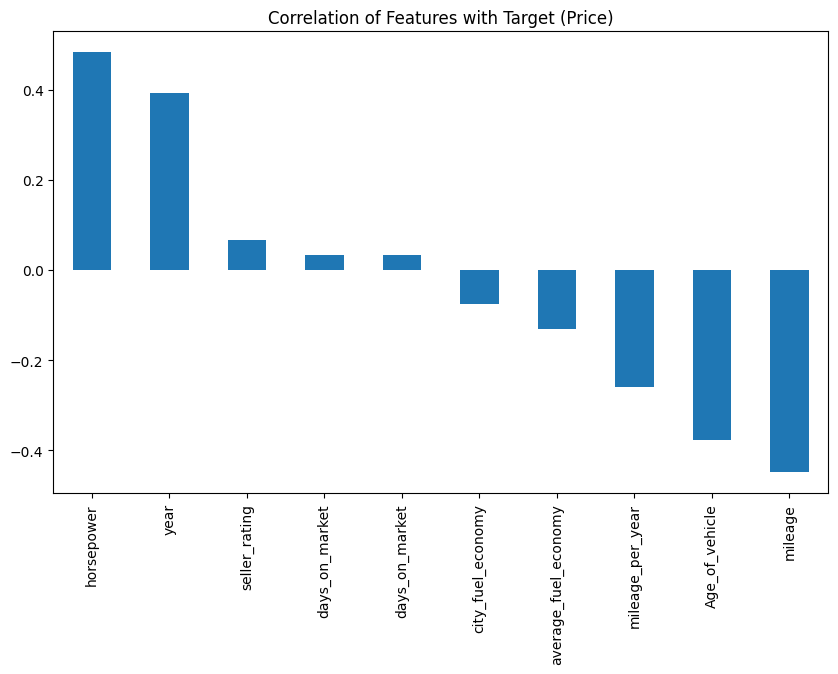

Selected Features based on Correlation: ['horsepower', 'Age_of_vehicle', 'year', 'mileage', 'mileage_per_year']


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns =["horsepower","Age_of_vehicle","city_fuel_economy","days_on_market","price","year","mileage","average_fuel_economy","seller_rating","days_on_market","mileage_per_year"]
print("Numerical Columns:", numerical_columns)
# Create a new DataFrame with only numerical columns
numerical_df = pandas_df[numerical_columns]
# Compute correlation matrix
correlation_matrix = numerical_df.corr()
# Filter correlations with the target variable
target_column = "price"
correlation_with_target = correlation_matrix[target_column].drop(target_column)

plt.figure(figsize=(10, 6))
correlation_with_target.sort_values(ascending=False).plot(kind='bar')
plt.title("Correlation of Features with Target (Price)")
plt.show()


selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()
print("Selected Features based on Correlation:", selected_features)


Selected Features with Correlation > ±0.2:
CAR_Make_Model    0.862992
engine_type       0.443739
has_accidents     0.338475
body_type         0.267897
dtype: float64


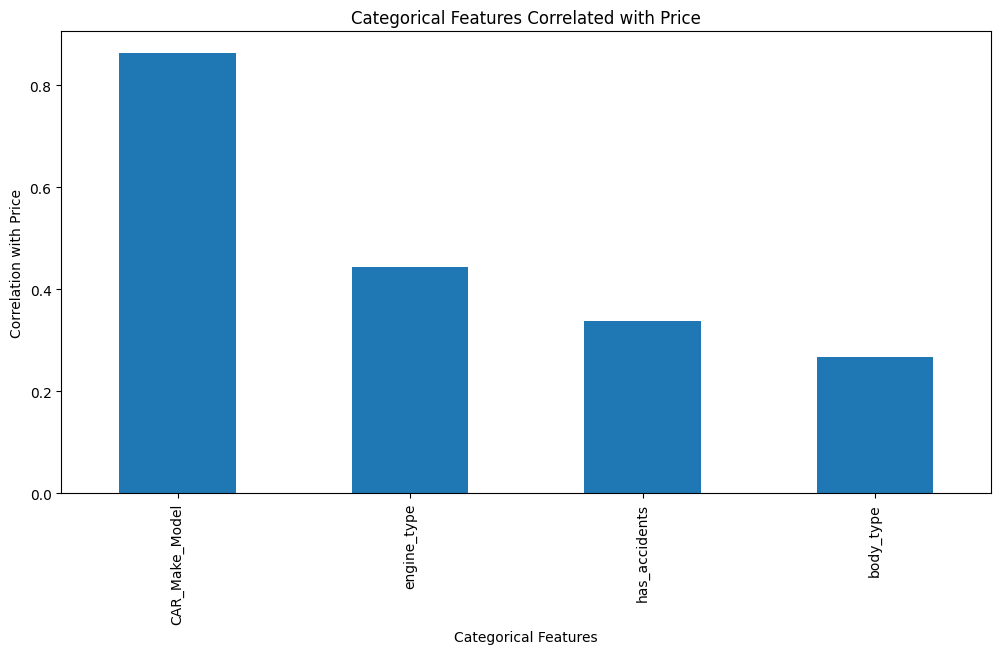

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Select categorical columns and target variable
categorical_columns = ["body_type", "engine_type", "fuel_type", "transmission", "city", "has_accidents", "CAR_Make_Model"]
price_column = pandas_df['price']

# Initialize a dictionary to store correlations
correlations = {}

# Calculate the mean price for each category in each feature and its correlation with price
for column in categorical_columns:
    # Map each category to its mean price
    mapped_feature = pandas_df.groupby(column)['price'].transform('mean')

    # Calculate the correlation between the transformed feature and price
    correlation = mapped_feature.corr(price_column)

    # Store the result
    correlations[column] = correlation

# Convert correlations dictionary to a sorted Series
correlation_series = pd.Series(correlations).sort_values(ascending=False)

# Set a threshold for feature selection
threshold = 0.2
selected_features = correlation_series[correlation_series.abs() > threshold]

# Display selected features
print("Selected Features with Correlation > ±0.2:")
print(selected_features)

# Visualize selected features
plt.figure(figsize=(12, 6))
selected_features.plot(kind='bar', title="Categorical Features Correlated with Price")
plt.xlabel("Categorical Features")
plt.ylabel("Correlation with Price")
plt.show()


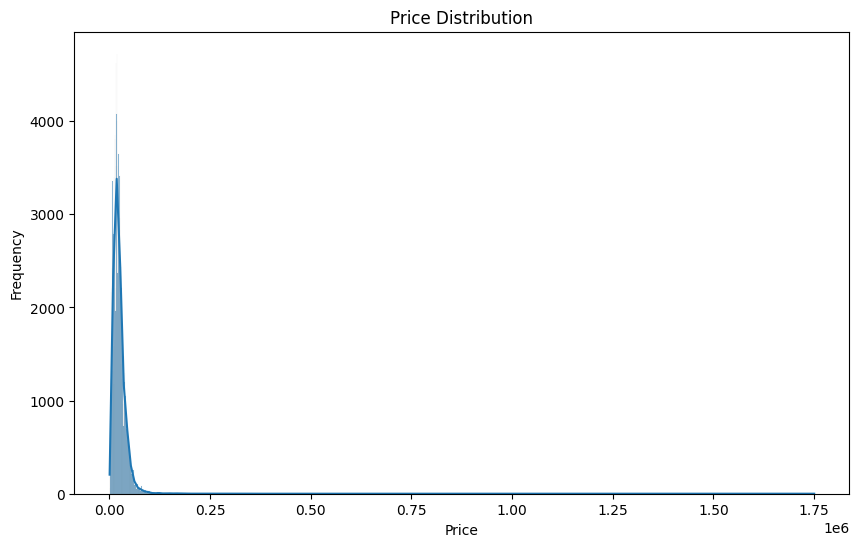

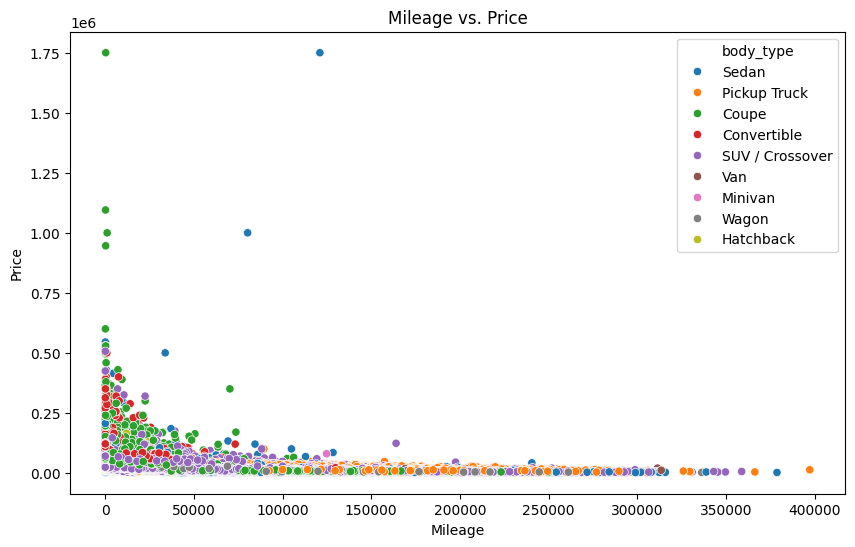

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


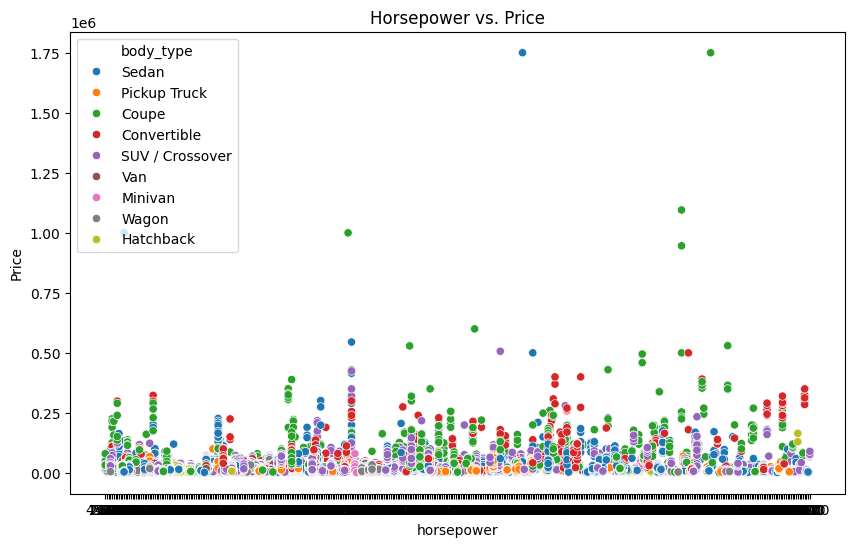

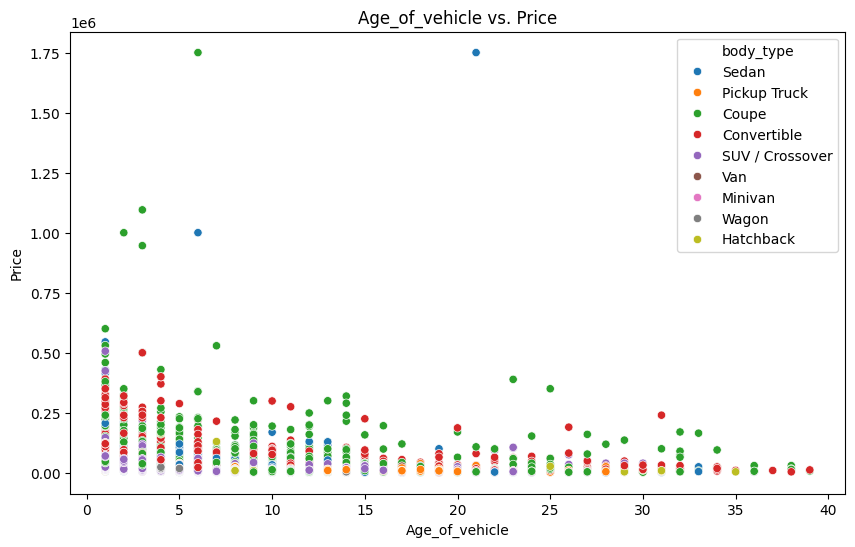

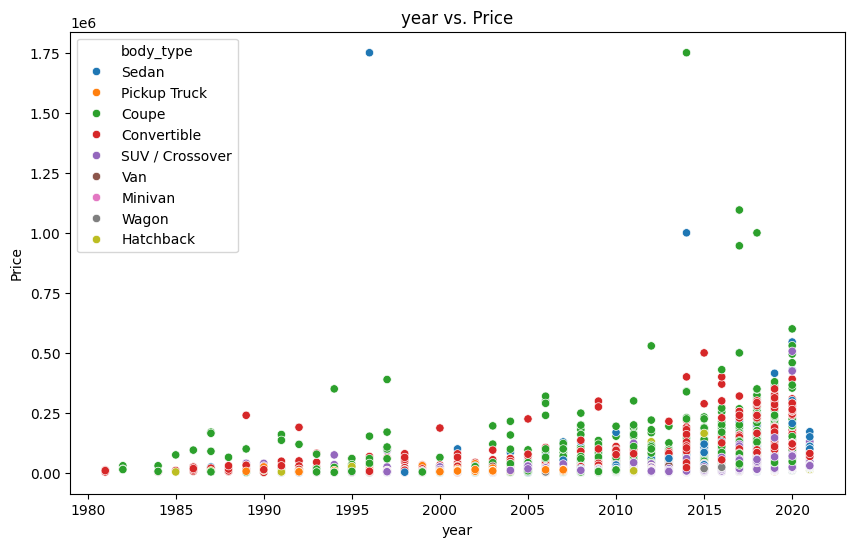

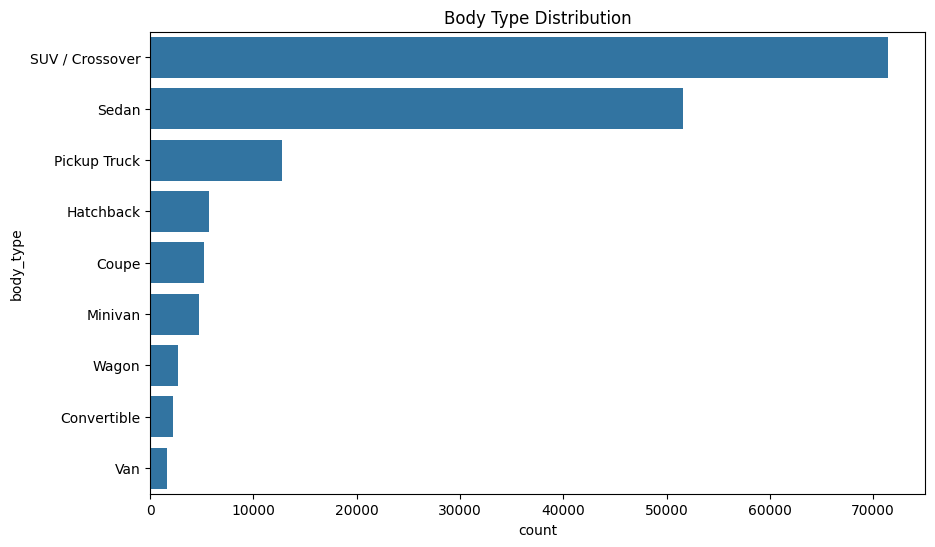

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize feature distributions
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Scatterplot: Mileage vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mileage', y='price', hue='body_type', data=pandas_df)
plt.title('Mileage vs. Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

# Scatterplot: Horsepower vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='horsepower', y='price', hue='body_type', data=pandas_df)
plt.title('Horsepower vs. Price')
plt.xlabel('horsepower')
plt.ylabel('Price')
plt.show()

# Scatterplot: Age_of_vehicle vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age_of_vehicle', y='price', hue='body_type', data=pandas_df)
plt.title('Age_of_vehicle vs. Price')
plt.xlabel('Age_of_vehicle')
plt.ylabel('Price')
plt.show()

# Scatterplot: year vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', hue='body_type', data=pandas_df)
plt.title('year vs. Price')
plt.xlabel('year')
plt.ylabel('Price')
plt.show()


# Count plot for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(y=pandas_df['body_type'], order=pandas_df['body_type'].value_counts().index)
plt.title('Body Type Distribution')
plt.show()


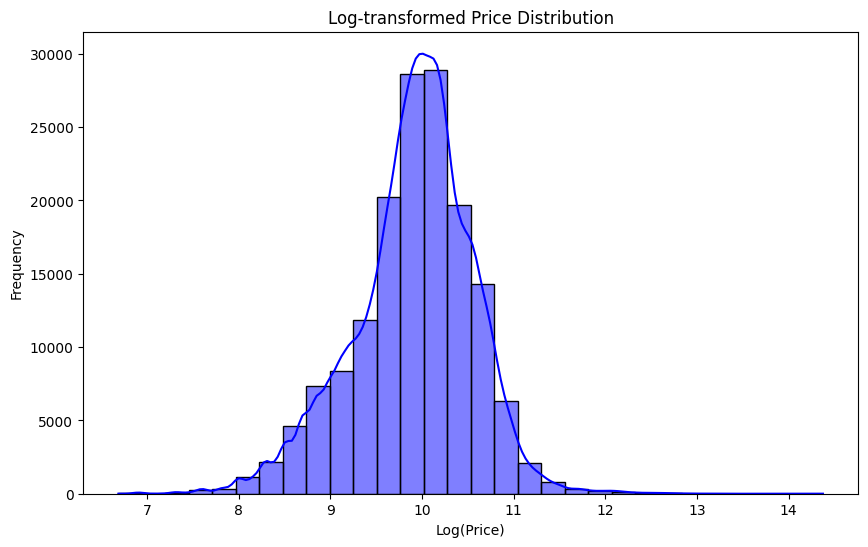

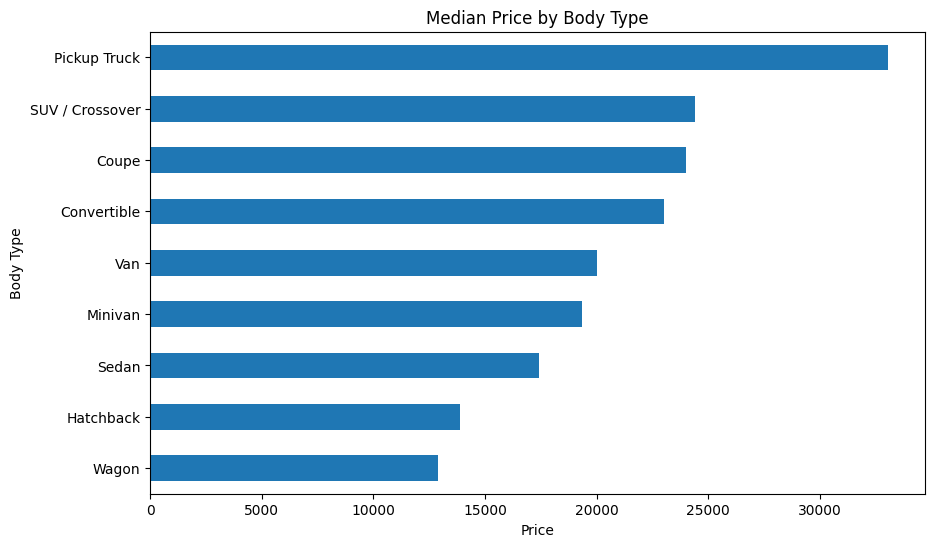

In [ ]:
# Log-transform price distribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df['log_price'] = np.log1p(pandas_df['price'])

plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['log_price'], kde=True, bins=30, color='blue')
plt.title('Log-transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

# Median price by body_type
median_price_body_type = pandas_df.groupby('body_type')['price'].median().sort_values()
median_price_body_type.plot(kind='barh', figsize=(10, 6))
plt.title('Median Price by Body Type')
plt.xlabel('Price')
plt.ylabel('Body Type')
plt.show()


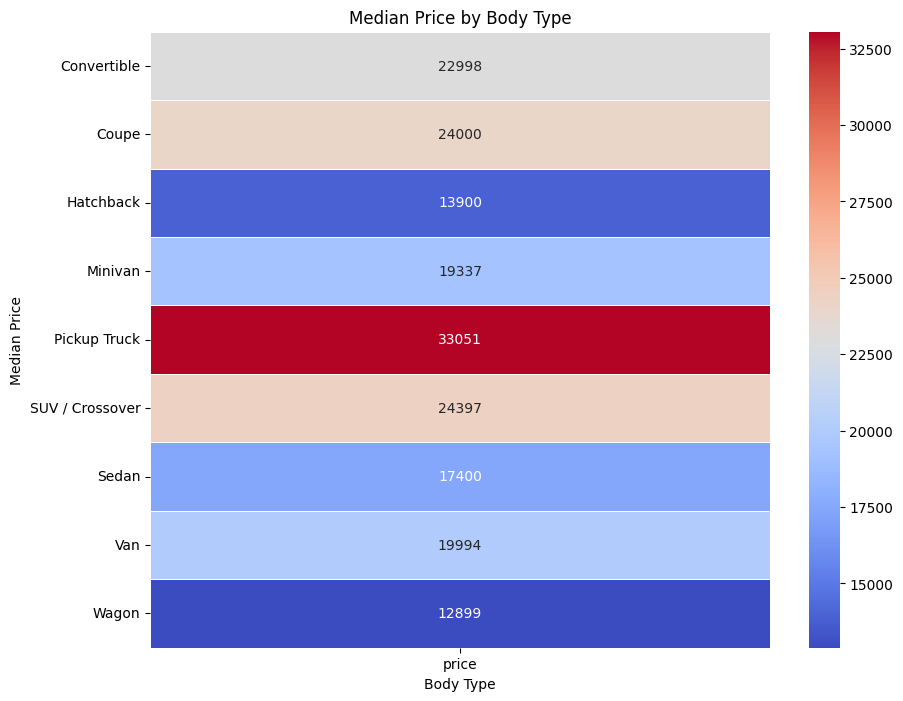

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the median price for each body type
heatmap_data = pandas_df.groupby('body_type')['price'].median().reset_index()

# Pivot the data for heatmap structure
heatmap_pivot = heatmap_data.pivot_table(index='body_type', values='price')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".0f", cmap="coolwarm", linewidths=0.5)
plt.title('Median Price by Body Type')
plt.xlabel('Body Type')
plt.ylabel('Median Price')
plt.show()


*italicized text*

```
Analysis
```



In [ ]:
# # Execute SQL query to count cities and retrieve the top 15
# table_df = spark.sql("""
#     SELECT count(*) from EDA_vw
# """)

# # Show the result
# table_df.show()

In [ ]:
# # Execute SQL query to count cities and retrieve the top 15
# table_df = spark.sql("""
#     SELECT transmission,year from filtered_table where transmission not in ('A','M')
# """)

# # Show the result
# table_df.show(500)

In [ ]:
# # Execute SQL query to count cities and retrieve the top 15
# table_df = spark.sql("""
#     SELECT distinct(transmission) from EDA_vw where transmission_display not in ('Automatic','Manual')
# """)

# # Show the result
# table_df.show()

In [ ]:
# Execute SQL query to count cities and retrieve the top 15
table_df = spark.sql("""
    SELECT count(*) from EDA_vw where transmission_display not in ('Automatic','Manual')
""")
# Show the result
table_df.show()

In [ ]:
# # Execute SQL query to count cities and retrieve the top 15
# # table_df = spark.sql("""SELECT * from EDA_vw where franchise_make is not null and franchise_make !='N/A' """)
# table_df = spark.sql("""SELECT distinct(year) from EDA_vw order by year """)
# # Show the result
# table_df.show(100)

In [ ]:
spark.sql('''SELECT Age_of_vehicle, AVG(mileage) AS avg_mileage
FROM EDA_vw
WHERE mileage = 0
GROUP BY Age_of_vehicle
ORDER BY Age_of_vehicle;
''').show(100)

In [ ]:
# Save to Parquet format
table_df.write.mode("overwrite").format("parquet").save("final_dataset.parquet")
# Save to CSV format
table_df.write.mode("overwrite").csv("final_dataset.csv", header=True)
